In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, filters, color

# Load images and convert to grayscale
im1 = cv2.imread('../exemples/photos 1 pièce/photo_piece1.jpeg')
im2 = cv2.imread('../exemples/photos 1 pièce/photo_piece2.jpeg')
im3 = cv2.imread('../exemples/photos 1 pièce/photo_piece3.jpeg')
im4 = cv2.imread('../exemples/photos 1 pièce/photo_piece4.jpeg')
im5 = cv2.imread('../exemples/photos 1 pièce/photo_piece5.jpeg')

# Grayscale versions for thresholding
im1g = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2g = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
im3g = cv2.cvtColor(im3, cv2.COLOR_RGB2GRAY)
im4g = cv2.cvtColor(im4, cv2.COLOR_RGB2GRAY)
im5g = cv2.cvtColor(im5, cv2.COLOR_RGB2GRAY)

# Now you can run the previous code to apply thresholding and display bounding boxes on original images.


## Try thresholding

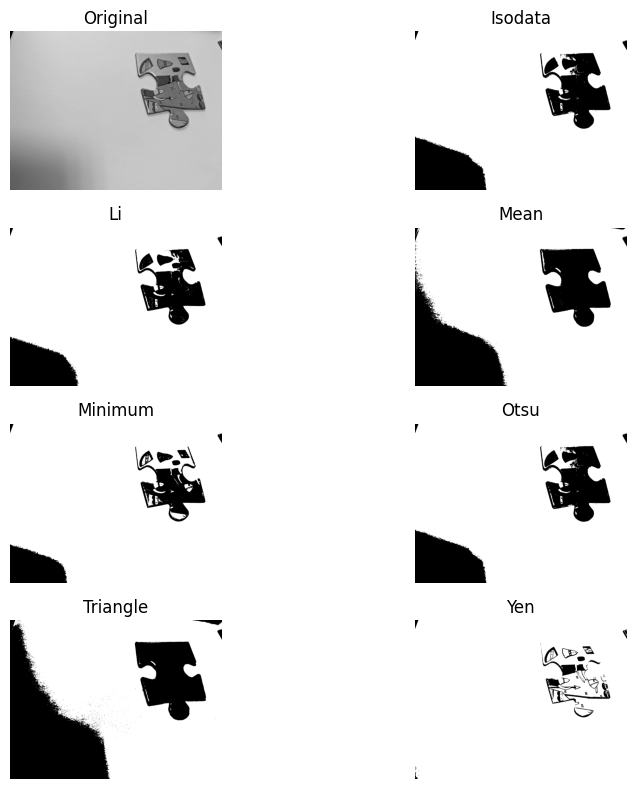

In [2]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(im1g, figsize=(10, 8), verbose=False)
plt.show()

## Find bounding boxes

### Benchmark box detection techniques

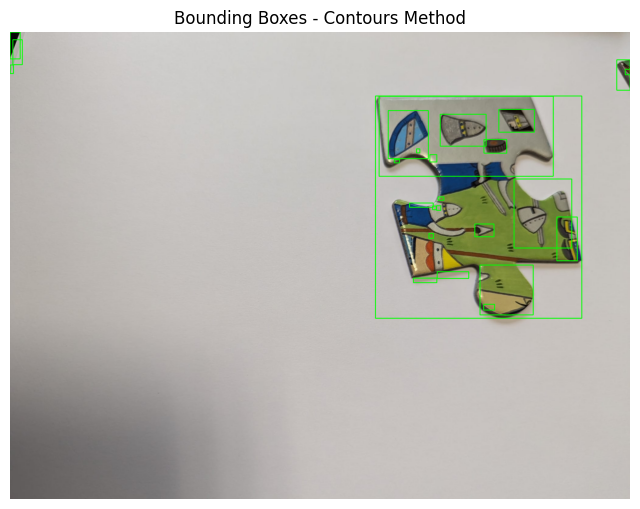

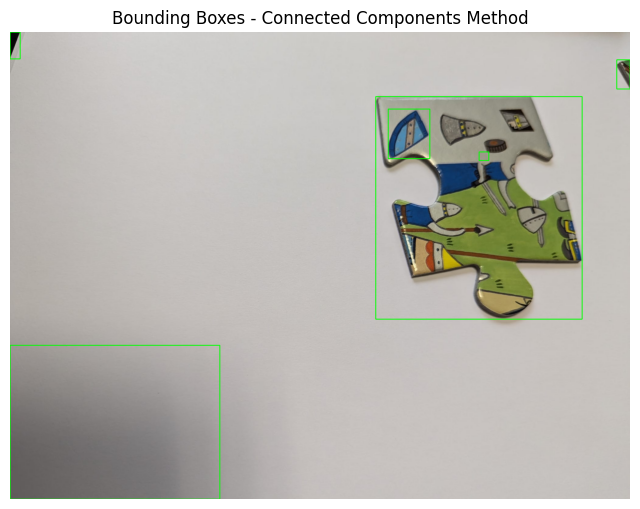

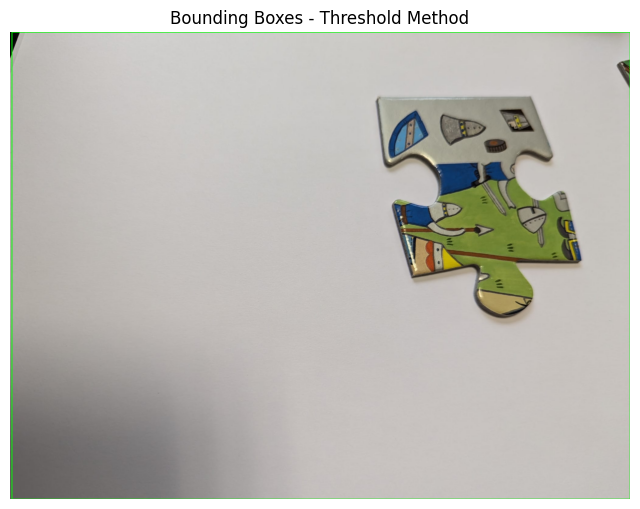

In [15]:

from typing import Tuple, List

def find_bounding_boxes(image: np.ndarray, method: str = 'contours') -> List[Tuple[int, int, int, int]]:
    """
    Find rectangle bounding boxes in an image using different methods.
    
    Args:
        image: Input image as numpy array (grayscale or BGR)
        method: Detection method ('contours', 'connected_components', or 'threshold')
    
    Returns:
        List of bounding boxes as (x, y, width, height)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    if method == 'contours':
        return _contour_method(gray)
    elif method == 'connected_components':
        return _connected_components_method(gray)
    elif method == 'threshold':
        return _threshold_method(gray)
    else:
        raise ValueError(f"Unknown method: {method}")

def _contour_method(gray: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """Contour-based detection method."""
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Find contours
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Get bounding boxes
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out too small boxes
        if w > 10 and h > 10:
            boxes.append((x, y, w, h))
    
    return boxes

def _connected_components_method(gray: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """Connected components-based detection."""
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    
    # Apply connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        thresh, connectivity=8
    )
    
    # Convert stats to bounding boxes
    boxes = []
    # Start from 1 to skip background
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filter out small components
        if area > 100:
            boxes.append((x, y, w, h))
    
    return boxes

def _threshold_method(gray: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """Simple threshold-based detection."""
    # Apply binary threshold
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)
    
    # Find non-zero points
    points = cv2.findNonZero(thresh)
    
    if points is not None:
        # Get bounding box of all points
        x, y, w, h = cv2.boundingRect(points)
        return [(x, y, w, h)]
    return []

def visualize_boxes(image: np.ndarray, boxes: List[Tuple[int, int, int, int]]) -> np.ndarray:
    """
    Draw bounding boxes on image for visualization.
    
    Args:
        image: Input image
        boxes: List of bounding boxes (x, y, width, height)
    
    Returns:
        Image with drawn boxes
    """
    result = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return result

def display_image_with_boxes(image: np.ndarray, boxes: List[Tuple[int, int, int, int]], title: str):
    """
    Display image with bounding boxes in Jupyter notebook.
    
    Args:
        image: Input image
        boxes: List of bounding boxes
        title: Title for the plot
    """
    result_image = visualize_boxes(image, boxes)
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Example usage:
# Find boxes using different methods
contour_boxes = find_bounding_boxes(im1, "contours")
cc_boxes = find_bounding_boxes(im1, "connected_components")
threshold_boxes = find_bounding_boxes(im1, "threshold")

# Display results directly in the notebook
display_image_with_boxes(im1, contour_boxes, "Bounding Boxes - Contours Method")
display_image_with_boxes(im1, cc_boxes, "Bounding Boxes - Connected Components Method")
display_image_with_boxes(im1, threshold_boxes, "Bounding Boxes - Threshold Method")


### Try to make it more robust

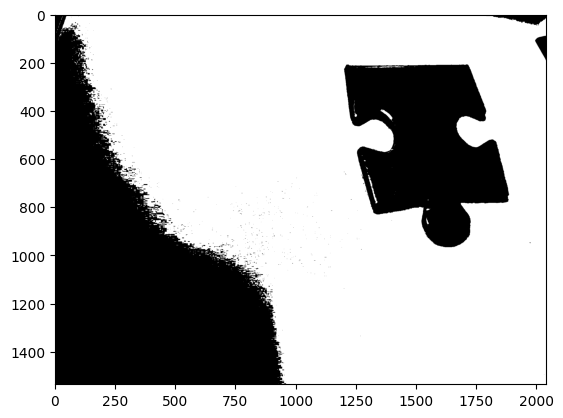

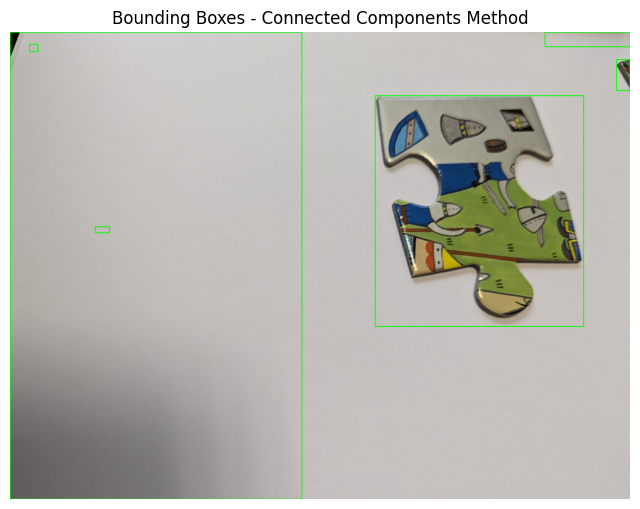

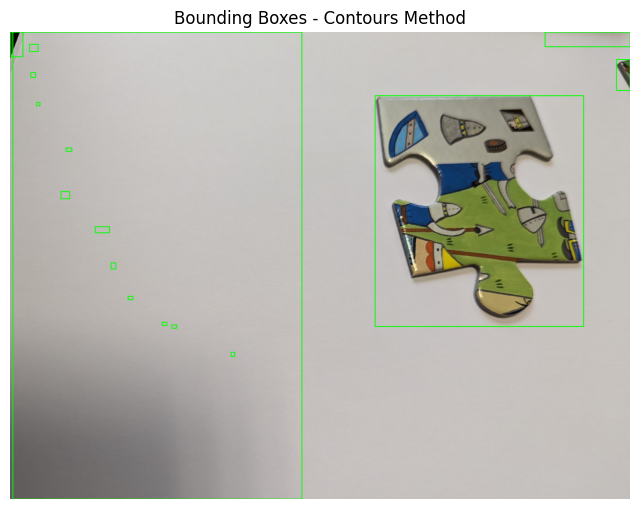

In [36]:

_, im1_binary = cv2.threshold(im1g, 100, 255, cv2.THRESH_TRIANGLE)
thresh = cv2.adaptiveThreshold(im1g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)
# Step 1: Adaptive thresholding (with low sensitivity)

plt.imshow(im1_binary, cmap='gray')

boxes_connected_components=_connected_components_method(im1_binary)
display_image_with_boxes(im1, boxes_connected_components, "Bounding Boxes - Connected Components Method")
boxes_contours=_contour_method(im1_binary)
display_image_with_boxes(im1, boxes_contours, "Bounding Boxes - Contours Method")

def try_triangle_connectedc(im1g):
    _, im1_binary = cv2.threshold(im1g, 100, 255, cv2.THRESH_TRIANGLE)
    boxes_connected_components=_connected_components_method(im1_binary)
    display_image_with_boxes(im1, boxes_connected_components, "Bounding Boxes - Connected Components Method")
    return boxes_connected_components



### try to remove the shadow



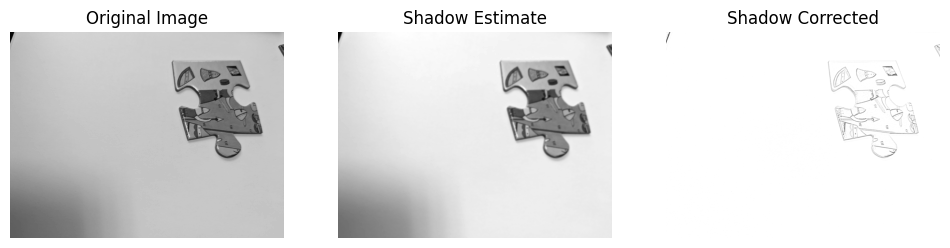

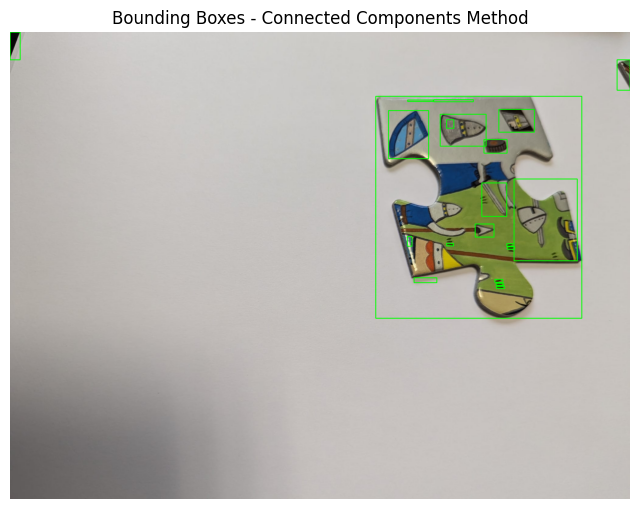

[(np.int32(0), np.int32(0), np.int32(33), np.int32(91)),
 (np.int32(1997), np.int32(91), np.int32(43), np.int32(100)),
 (np.int32(1203), np.int32(211), np.int32(678), np.int32(730)),
 (np.int32(1308), np.int32(223), np.int32(84), np.int32(5)),
 (np.int32(1394), np.int32(222), np.int32(130), np.int32(7)),
 (np.int32(1608), np.int32(254), np.int32(117), np.int32(75)),
 (np.int32(1245), np.int32(258), np.int32(132), np.int32(158)),
 (np.int32(1415), np.int32(270), np.int32(151), np.int32(105)),
 (np.int32(1436), np.int32(288), np.int32(24), np.int32(28)),
 (np.int32(1559), np.int32(353), np.int32(76), np.int32(45)),
 (np.int32(1658), np.int32(483), np.int32(208), np.int32(269)),
 (np.int32(1552), np.int32(496), np.int32(82), np.int32(110)),
 (np.int32(1530), np.int32(631), np.int32(62), np.int32(43)),
 (np.int32(1307), np.int32(672), np.int32(15), np.int32(32)),
 (np.int32(1436), np.int32(695), np.int32(23), np.int32(8)),
 (np.int32(1634), np.int32(696), np.int32(24), np.int32(8)),
 (np.i

In [37]:


# Step 1: Estimate shadow by blurring the image
shadow_estimate = cv2.GaussianBlur(im1g, (21, 21), 0)

# Step 2: Normalize the image by dividing by the shadow estimate
shadow_corrected = cv2.divide(im1g, shadow_estimate, scale=255)

# Plotting the images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(im1g, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Shadow Estimate")
plt.imshow(shadow_estimate, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Shadow Corrected")
plt.imshow(shadow_corrected, cmap='gray')
plt.axis("off")

plt.show()


try_triangle_connectedc(shadow_corrected)

In [39]:
_connected_components_method(im2g)
_connected_components_method(im3g)
_connected_components_method(im4g)
_connected_components_method(im5g)

[(np.int32(1390), np.int32(0), np.int32(24), np.int32(67)),
 (np.int32(171), np.int32(160), np.int32(787), np.int32(796)),
 (np.int32(251), np.int32(597), np.int32(101), np.int32(128)),
 (np.int32(506), np.int32(619), np.int32(27), np.int32(14)),
 (np.int32(502), np.int32(639), np.int32(60), np.int32(36)),
 (np.int32(614), np.int32(692), np.int32(23), np.int32(23)),
 (np.int32(600), np.int32(740), np.int32(49), np.int32(39)),
 (np.int32(600), np.int32(772), np.int32(24), np.int32(21)),
 (np.int32(585), np.int32(783), np.int32(54), np.int32(66)),
 (np.int32(608), np.int32(797), np.int32(32), np.int32(43)),
 (np.int32(0), np.int32(1216), np.int32(1536), np.int32(824))]

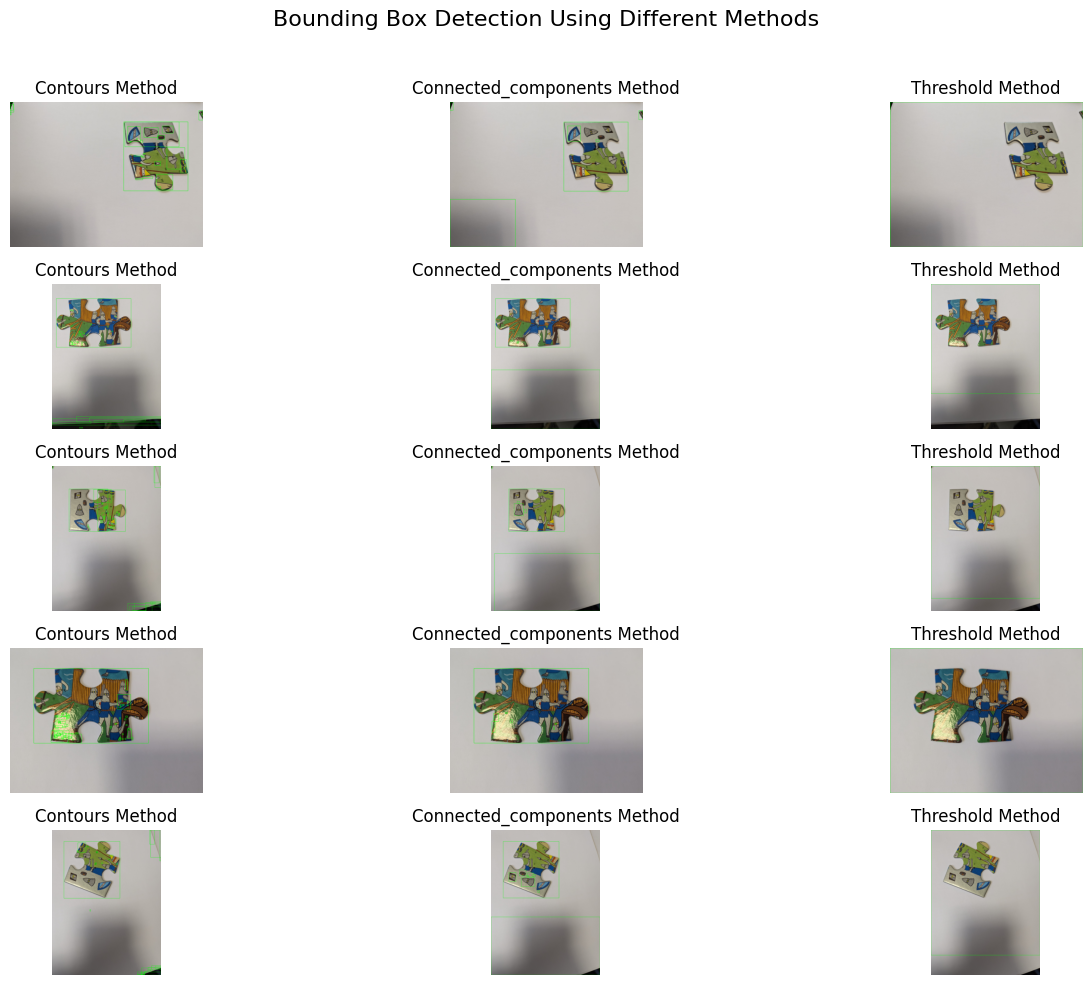

In [40]:
from typing import List
import cv2
import matplotlib.pyplot as plt
import numpy as np

def compact_plot(images: List[np.ndarray], methods: List[str]):
    """
    Create a compact plot of bounding box results for a list of images using multiple methods.
    
    Args:
        images: List of input images
        methods: List of method names ('contours', 'connected_components', 'threshold')
    """
    fig, axs = plt.subplots(len(images), len(methods), figsize=(15, 10))
    fig.suptitle("Bounding Box Detection Using Different Methods", fontsize=16)

    for i, image in enumerate(images):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        for j, method in enumerate(methods):
            boxes = find_bounding_boxes(gray_image, method)
            result_image = visualize_boxes(image, boxes)
            axs[i, j].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            axs[i, j].set_title(f"{method.capitalize()} Method")
            axs[i, j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# List of loaded images and methods to visualize
images = [im1, im2, im3, im4, im5]
methods = ['contours', 'connected_components', 'threshold']

# Display the compact plot
compact_plot(images, methods)


[(np.int32(0), np.int32(0), np.int32(960), np.int32(1536)), (np.int32(1760), np.int32(0), np.int32(280), np.int32(48)), (np.int32(64), np.int32(40), np.int32(28), np.int32(24)), (np.int32(1995), np.int32(90), np.int32(45), np.int32(102)), (np.int32(1201), np.int32(209), np.int32(686), np.int32(759)), (np.int32(280), np.int32(640), np.int32(47), np.int32(20))]


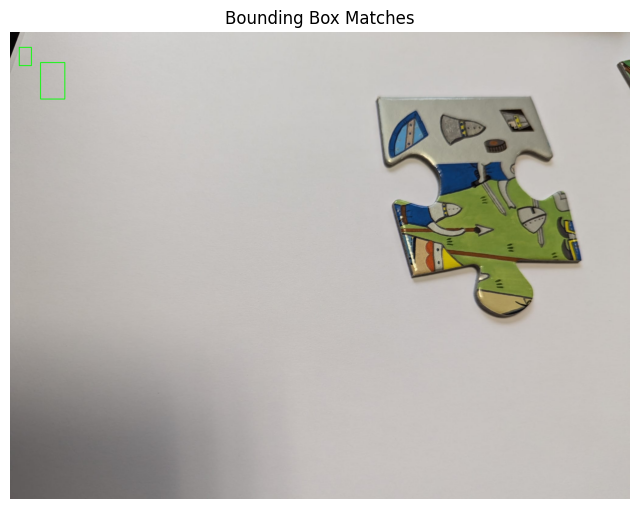

In [44]:
print(boxes_connected_components)

def inter_boxes(boxes1, boxes2):
    n1=len(boxes1)
    n2=len(boxes2)
    simi=np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            x1, y1, w1, h1 = boxes1[i]
            x2, y2, w2, h2 = boxes2[j]
            inter=max(0, min(x1+w1, x2+w2) - max(x1, x2)) * max(0, min(y1+h1, y2+h2) - max(y1, y2))
            union=w1*h1+w2*h2-inter
            simi[i,j]=inter/union
    best_box=np.argmax(simi, axis=1)
    return best_box

inter_boxes(boxes_connected_components, boxes_connected_components)
from typing import List, Tuple
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_inter_boxes(image: np.ndarray, boxes1: List[Tuple[int, int, int, int]], 
                        boxes2: List[Tuple[int, int, int, int]], best_matches: List[int]):
    """
    Display an image with bounding boxes and highlight matched boxes between two sets.
    
    Args:
        image: The input image (BGR format).
        boxes1: List of bounding boxes from the first method.
        boxes2: List of bounding boxes from the second method.
        best_matches: List of indices indicating the best-matched box in boxes2 for each box in boxes1.
    """
    # Convert image to RGB for plotting
    display_image = image.copy()
    
    # Draw boxes from the first set in blue
    for (x, y, w, h) in boxes1:
        cv2.rectangle(display_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red for first set
    
    # Draw boxes from the second set in green
    for idx, (x, y, w, h) in enumerate(boxes2):
        if idx in best_matches:
            color = (0, 255, 0)  # Green for matched boxes
        else:
            color = (255, 0, 0)  # Blue for unmatched boxes
        cv2.rectangle(display_image, (x, y), (x + w, y + h), color, 2)
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.title("Bounding Box Matches")
    plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Example usage with test data (replace image with actual image if available)
# Using placeholder images and bounding boxes (assuming im1 is loaded)
boxes_connected_components = [(30, 50, 40, 60), (100, 100, 80, 120)]  # Sample boxes for testing
best_matches = inter_boxes(boxes_connected_components, boxes_connected_components)

# Display results with matched boxes
display_inter_boxes(im1, boxes_connected_components, boxes_connected_components, best_matches)

